# Testing Binary Structure Models on Multivariate Data

Much of this notebook is adapted from notebooks/bivariate-categorical/03_meta_learning.ipynb

In [42]:
import sys
sys.path.insert(0, '../..')

In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange as tnrange

from cs330.data_generators.multivariate_categorical import MultiCategorical
from cs330.data_generators.causal_graph import CausalGraph
from cs330.models.augmented_binary_models import *
from cs330.models.augmented_binary_model_trainer import *

#from models import StructuralModel

In [44]:
# Trial Setup
if False:
    TRIAL_ID = "binary_with_confounder"
    N = 10
    M = 3

    # Create graph and data generator
    data_gen = MultiCategorical(N, M)
    data_gen.graph.B = np.array([
        [0, 0, 0],
        [1, 0, 0],
        [1, 0, 0]
    ])
    # Determine node indices to compare
    A = 1
    B = 2

if True:
    TRIAL_ID = "binary_with_collider"
    N = 10
    M = 3

    # Create graph and data generator
    data_gen = MultiCategorical(N, M)
    data_gen.graph.B = np.array([
        [0, 0, 0],
        [0, 0, 0],
        [1, 1, 0]
    ])
    # Determine node indices to compare
    A = 0
    B = 1

In [45]:
# Create Model
# model = StructuralModel(N, dtype=torch.float64)
model = CauseOnlyBinaryStructureModel(N, M, A, B)

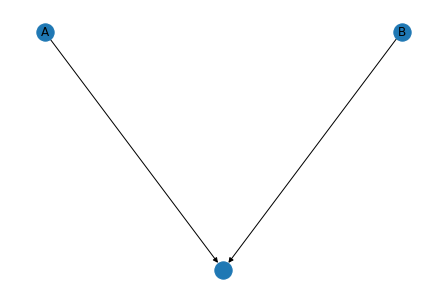

In [46]:
# Save labeled graph image
data_gen.graph.visualize(labels={A: "A", B: "B"})
plt.savefig(f"{TRIAL_ID}.graph.png")

In [ ]:
model_handler = AugmentedBinaryModelHandler(
    data_gen, model,
    inner_lr = 1e-1,
    outer_lr = 1e-2,
    transfer_episode_count = 500,
    transfer_episode_gradient_steps = 20,
    transfer_episode_batch_size = 50,
    pretrain_episode_batch_size = 500
)

In [48]:
# Training constants
num_runs = 4 # 10

In [49]:
structure_likelihoods = torch.zeros((num_runs, model_handler.transfer_episode_count, model_handler.hypothesis_count()))

for i in tnrange(num_runs):
    # Step 1: Sample a joint distribution before intervention
    data_gen.reset_all_distributions()

    model_handler.reset()

    # Step 1.5: Save samples to pretrain hypothesis models before each transfer training iteration
    model_handler.pretrain_samples = data_gen.sample(pretrain_batch_size)

    # Step 2: Train structure model over multiple transfer episodes
    model_handler.train_structure()

    # Update logs
    structure_likelihoods[i, :, :] = model_handlers.structure_likelihoods

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

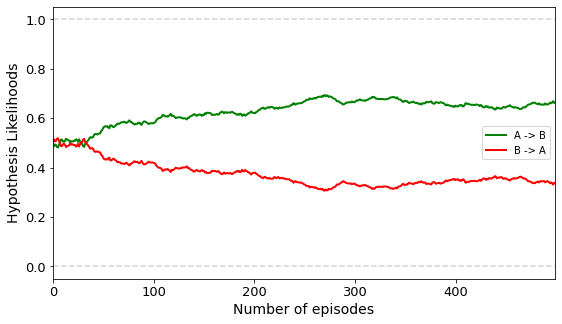

In [52]:
hypothesis_curves = {}
for i in range(model_handler.hypothesis_count()):
    name = model_handler.structural_model.hypothesis_names()[i]
    curves = structure_likelihoods[:, :, i]
    hypothesis_curves[name] = curves

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
for name, curves in hypothesis_curves.items():
    ax.plot(np.percentile(curves, 50, axis=0), lw=2, color='g', label=name)
ax.legend()

ax.set_xlim([0, num_transfer - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel("Hypothesis Likelihoods", fontsize=14)

plt.savefig(f"{TRIAL_ID}_median_alphas.png")
plt.show()